In [36]:
%matplotlib inline

from collections import defaultdict
import functools
import os

import h5py
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from scipy import stats
sns.set_style('ticks')

In [37]:
# Read counts in millions
read_counts = {
    'rep_1': 27.148602,
    'rep_2': 23.52997,
    'rep_1_input': 29.02927,
    'rep_2_input': 30.379016,
    'groseq': 11.806518
}

In [38]:
f = h5py.File('matrix_data/DRIP_Seq.hdf5', 'r') 

In [39]:
drip_signal = {}

drip_signal['ho_ho'] = (
    np.array(f['DRIP_around_origins']['HO_HO_rep_1'])/read_counts['rep_1'] +
    np.array(f['DRIP_around_origins']['HO_HO_rep_2'])/read_counts['rep_2']
)/2

drip_signal['ho_ho_input'] = (
    np.array(f['DRIP_around_origins']['HO_HO_rep_1_input'])/read_counts['rep_1_input'] +
    np.array(f['DRIP_around_origins']['HO_HO_rep_2_input'])/read_counts['rep_2_input']
)/2

drip_signal['cd_cd'] = (
    np.array(f['DRIP_around_origins']['CD_CD_rep_1'])/read_counts['rep_1'] +
    np.array(f['DRIP_around_origins']['CD_CD_rep_2'])/read_counts['rep_2']
)/2

drip_signal['cd_cd_input'] = (
    np.array(f['DRIP_around_origins']['CD_CD_rep_1_input'])/read_counts['rep_1_input'] +
    np.array(f['DRIP_around_origins']['CD_CD_rep_2_input'])/read_counts['rep_2_input']
)/2

drip_signal['input'] = np.concatenate([drip_signal['ho_ho_input'], drip_signal['cd_cd_input']])

In [35]:
f.close()

In [40]:
def closest_L2_pairs(needles, haystack):
    n_needles = needles.shape[0]
    n_haystack = haystack.shape[0]
    dists = np.zeros((n_needles, n_haystack))
    dists = np.sqrt((dists.T + np.sum(np.square(needles), axis=1)).T 
                    + np.sum(np.square(haystack), axis=1) 
                    - 2* needles.dot(haystack.T))
    return dists

def standardize(column):
    return (column - np.mean(column))/(np.std(column))

def bootstrap_aggregate_plots(variable_1, variable_2, distance_list, n_repeats, verbose=True):
    resampled_var1 = np.zeros((n_repeats, variable_1.shape[1]), dtype=np.float32)
    resampled_var2 = np.zeros((n_repeats, variable_2.shape[1]), dtype=np.float32)

    for i in range(n_repeats):
        if verbose and not i % (n_repeats//10): 
            print(i)
        random_sample = np.random.choice(len(variable_1) - 1, len(variable_1) - 1, replace=True)
        resampled_var1[i, :] = variable_1[random_sample, :].mean(axis=0)
        resampled_var2[i, :] = variable_2[distance_list[random_sample], :].mean(axis=0)
    return np.array(resampled_var1, dtype=np.float16), np.array(resampled_var2, dtype=np.float32)

def bootstrap_one_sample(variable_1, n_repeats, verbose=True):
    resampled_var1 = np.zeros((n_repeats, variable_1.shape[1]), dtype=np.float32)
    for i in range(n_repeats):
        if verbose and not i % (n_repeats//10): 
            print(i)
        random_sample = np.random.choice(len(variable_1) - 1, len(variable_1) - 1, replace=True)
        resampled_var1[i, :] = variable_1[random_sample, :].mean(axis=0)
    return resampled_var1

def closest_unique_pairs(needles, haystack, max_number=1):
    dists = closest_L2_pairs(needles, haystack)
    sorted_dists = np.argsort(dists, axis=1)
    used = defaultdict(int)
    output = np.zeros((len(needles)))
    for i in range(len(output)):
        for j in sorted_dists[i ,:]:
            if j not in used or used[j] < max_number:
                output[i] = j
                used[j] += 1
                break
        else:
            output[i] = -1
    return np.array(output, dtype=np.int32)

In [41]:
ho_match_data = pd.read_csv('match_data/match_data_ho_ho.tsv', sep='\t')
cd_match_data = pd.read_csv('match_data/match_data_cd_cd.tsv', sep='\t')

cd_mean_data = cd_match_data.copy()
ho_mean_data = ho_match_data.copy()

all_data = pd.concat([cd_mean_data, ho_match_data])

for i in list(cd_mean_data.columns):
    cd_mean_data[i] = (cd_mean_data[i] - all_data[i].mean())/all_data[i].std()

for i in list(ho_mean_data.columns):
    ho_mean_data[i] = (ho_mean_data[i] - all_data[i].mean())/all_data[i].std()

In [42]:
columns = ['replication_timing','gc_bias', 'total_groseq']
min_distances_cd_to_ho = closest_unique_pairs(cd_mean_data[columns].as_matrix(), 
                                              ho_mean_data[columns].as_matrix(), 
                                              max_number=100
                                             )
min_distances_ho_to_cd = closest_unique_pairs(ho_mean_data[columns].as_matrix(), 
                                              cd_mean_data[columns].as_matrix(), 
                                              max_number=100)

In [50]:
ho_bootstrap, cd_bootstrap = bootstrap_aggregate_plots(drip_signal['ho_ho'], 
                                                       drip_signal['cd_cd'], 
                                                       min_distances_ho_to_cd, 
                                                       50000, # For paper, use 1e6 resamples, intentionally decreased here
                                                       verbose=True)


0
5000
10000
15000
20000
25000
30000
35000
40000
45000


In [51]:
input_bootstrap = bootstrap_one_sample(drip_signal['input'], 50000, verbose=True)

0
5000
10000
15000
20000
25000
30000
35000
40000
45000


In [52]:
def plot_median_with_95ci(bootstrap_sample, color):
    fig = plt.plot(np.arange(-12, 12, 0.1), np.mean(bootstrap_sample, axis=0), color=color)
    lower_bound = np.percentile(bootstrap_sample, 2.5, axis=0)
    upper_bound = np.percentile(bootstrap_sample, 97.5, axis=0)
    plt.fill_between(np.arange(-12, 12, 0.1), lower_bound, upper_bound, color=color, alpha = 0.5)
    return fig

(-12, 12)

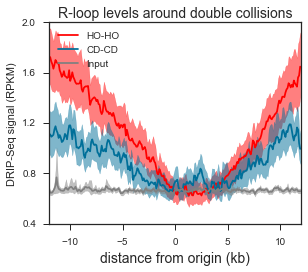

In [53]:
mpl.rc('font', family='arial')
plt.figure(figsize=(5.0,4.0))
fig = plot_median_with_95ci(ho_bootstrap[0:240, :] * 10, 'red')
fig = fig[0]
plot_median_with_95ci(cd_bootstrap[0:240, :] * 10, '#006F99')
plot_median_with_95ci(input_bootstrap[0:240, :] * 10, 'grey')
plt.legend(['HO-HO', 'CD-CD', 'Input'], loc='upper left')
plt.ylim(0.6,2.0)
fig.axes.yaxis.tick_left()
fig.axes.xaxis.tick_bottom()
plt.gcf().subplots_adjust(bottom=0.20, left = 0.20)
plt.yticks(np.arange(0.4, 2.4, 0.4))
plt.xticks(np.arange(-15, 15, 5))
plt.ylabel('DRIP-Seq signal (RPKM)')
plt.xlabel('distance from origin (kb)', fontsize=14)
plt.title('R-loop levels around double collisions', fontsize=14)
plt.xlim(-12,12)

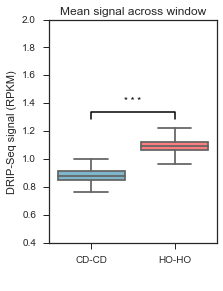

In [54]:
# Signal boxplot
fig, ax = plt.subplots(figsize=(3,4), sharey=True)

upstream_data = pd.DataFrame({'HO-HO': ho_bootstrap[:, 0:240].mean(axis=1) * 10, 
              'CD-CD':cd_bootstrap[:, 0:150].mean(axis=1) * 10})

variable_colors = ['#7fb6cb', '#fd7e7e']
sns.boxplot( x='variable', y='value', data = pd.melt(upstream_data), 
            ax=ax, palette=variable_colors, saturation=1, sym = '')
ax.set_ylim(0.4, 2.0)
ax.set_ylabel('DRIP-Seq signal (RPKM)')
ax.set_title('Mean signal across window')

ax.tick_params( axis='x',
    which='both',
    bottom='on',
    top='off',         
    labelbottom='on') 

ax.tick_params( axis='y',
    which='both',
    right='off') 


patches = [mpl.patches.Patch(color=color) for color in variable_colors]

ax.set_xlabel('|', color='white', fontsize=14)

#ax.legend(labels = ['CD-CD', 'HO-HO'], handles=patches)
x1, x2 = 0, 1  
y, h, col = upstream_data['HO-HO'].max() , 0.05, 'k'
ax.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
ax.text((x1+x2)*.5, y+h + 0.05, "* * *", ha='center', va='bottom', color=col)